<a href="https://colab.research.google.com/github/inesamorim/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    
---
# Exploring Counterfactual Fairness under Gender Imbalance in Health Decision Models: From Diagnosis to Insurance Acceptance

</div>

---
## Problem Context
---

The rapid integration of artificial intelligence (AI) into health-related decision systems has introduced both opportunities for efficiency and risks of bias amplification. Predictive models trained on real-world medical data often inherit the structural imbalances and historical inequalities present in society. One of the most pervasive forms of such imbalance is gender bias: women have been historically under-represented or misrepresented in clinical datasets, leading to models that may perform less accurately or unfairly across genders.

In health diagnosis, AI models may systematically underpredict disease risk in female patients due to biased patterns in data collection, feature representation, or label assignment. For example, cardiovascular disease datasets, such as the UCI Heart Disease dataset, often contain a disproportionate number of male samples, which can cause diagnostic models to learn male-centric associations. This imbalance raises concerns about fairness and reliability when deploying such systems in real-world medical contexts, where misclassification can have serious ethical and clinical implications.

Similarly, in the domain of health insurance acceptance, algorithmic decision-making systems may propagate or even intensify these disparities. Models trained on socioeconomic and demographic attributes risk unfairly penalizing certain groups — such as women or minority populations — through indirect correlations between sensitive variables (like gender) and financial or medical risk indicators. This can lead to discriminatory outcomes in access to insurance, pricing, or policy approval.

The study of **counterfactual fairness** provides a principled approach to evaluate and mitigate such biases. Instead of merely comparing performance metrics between groups, counterfactual fairness examines whether an individual would have received the same model prediction had their sensitive attribute (e.g., gender) been different, all else being equal. By integrating counterfactual analysis into diagnostic and insurance decision models, this project aims to uncover the influence of gender imbalance on predictive behavior and explore methods for achieving fairer and more transparent health-related AI systems.

---
## Google Drive Set-Up
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/inesamorim/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance.git /content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance

# Then just link it to the current working directory
%cd /content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance')

In [58]:
%pip install -r "./requirements.txt"

In [ ]:
#%reload_ext autoreload
#%autoreload 2

---
## Module Imports
---

In [61]:
from ucimlrepo import fetch_ucirepo #load the function to fetch datasets from UCI ML Repository
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *  #import all functions from utils.py
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score
import dice_ml
from dice_ml import Dice
from imblearn.over_sampling import SMOTE
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget
from data_auditor import DataProfiler, FairnessEngine
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate,
    false_positive_rate
)
import shap

<div align="center">
    
---
# Heart Disease Data

</div>

---
## 1. Data Overview
---

In [ ]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

In [ ]:
# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets
X = pd.DataFrame(data=heart_disease.data.features, columns=heart_disease.feature_names)
y = pd.DataFrame(heart_disease.data.targets, columns=heart_disease.target_names)

# Combine
heart_disease_df = pd.concat([X, y], axis=1)
heart_disease_df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0

In [ ]:
#save
heart_disease_df.to_csv('./datasets/heart_disease.csv', index=False)

---
## 2. Exploratory Data Analysis
---

In [ ]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


This study uses the **Cleveland Heart Disease Dataset** from the UCI Machine Learning Repository.
The dataset contains clinical and demographic attributes commonly used in heart disease diagnosis.
Below is a summary of the **14 selected attributes** (13 predictors + 1 target) used in this analysis:

| **Feature**                                        | **Description**                                                                                                                          | **Type / Range**      | **Notes**                                                      |
| -------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | --------------------- | -------------------------------------------------------------- |
| **age**                                            | Age of the patient in years.                                                                                                             | Continuous            | Represents risk factor increasing with age.                    |
| **sex**                                            | Biological sex (1 = male, 0 = female).                                                                                                   | Binary (categorical)  | Sensitive attribute used in fairness analysis.                 |
| **cp (chest pain type)**                           | Type of chest pain experienced. <br>1 = Typical angina <br>2 = Atypical angina <br>3 = Non-anginal pain <br>4 = Asymptomatic             | Categorical (1–4)     | Clinically relevant indicator of heart disease.                |
| **trestbps (resting blood pressure)**              | Resting blood pressure (mm Hg) measured upon hospital admission.                                                                         | Continuous            | Often used to assess hypertension.                             |
| **chol (serum cholesterol)**                       | Serum cholesterol in mg/dl.                                                                                                              | Continuous            | High levels are a known cardiac risk factor.                   |
| **fbs (fasting blood sugar)**                      | Fasting blood sugar >120 mg/dl (1 = true, 0 = false).                                                                                    | Binary                | Indicator of diabetes; related to cardiovascular risk.         |
| **restecg (resting electrocardiographic results)** | 0 = Normal <br>1 = ST-T wave abnormality <br>2 = Left ventricular hypertrophy                                                            | Categorical (0–2)     | Reflects electrical activity and possible heart abnormalities. |
| **thalach (maximum heart rate achieved)**          | Maximum heart rate reached during exercise.                                                                                              | Continuous            | Lower values may indicate cardiac limitation.                  |
| **exang (exercise-induced angina)**                | Whether exercise-induced angina occurred (1 = yes, 0 = no).                                                                              | Binary                | Associated with cardiac distress during exertion.              |
| **oldpeak**                                        | ST depression induced by exercise relative to rest.                                                                                      | Continuous            | Measures heart stress during physical activity.                |
| **slope**                                          | Slope of the peak exercise ST segment. <br>1 = Upsloping <br>2 = Flat <br>3 = Downsloping                                                | Categorical (1–3)     | Indicates heart function response to exercise.                 |
| **ca**                                             | Number of major vessels (0–3) colored by fluoroscopy.                                                                                    | Discrete              | Reflects vessel blockage; higher values = worse condition.     |
| **thal**                                           | Thalassemia test result. <br>3 = Normal <br>6 = Fixed defect <br>7 = Reversible defect                                                   | Categorical (3, 6, 7) | Diagnostic measure for blood-related cardiac issues.           |
| **num (target)**                                   | Diagnosis of heart disease (angiographic disease status). <br>0 = <50% narrowing (no disease) <br>1–4 = >50% narrowing (disease present) | Categorical (0–4)     | For modeling, values 1–4 are grouped as **1 (disease)**.       |



### **Target**

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


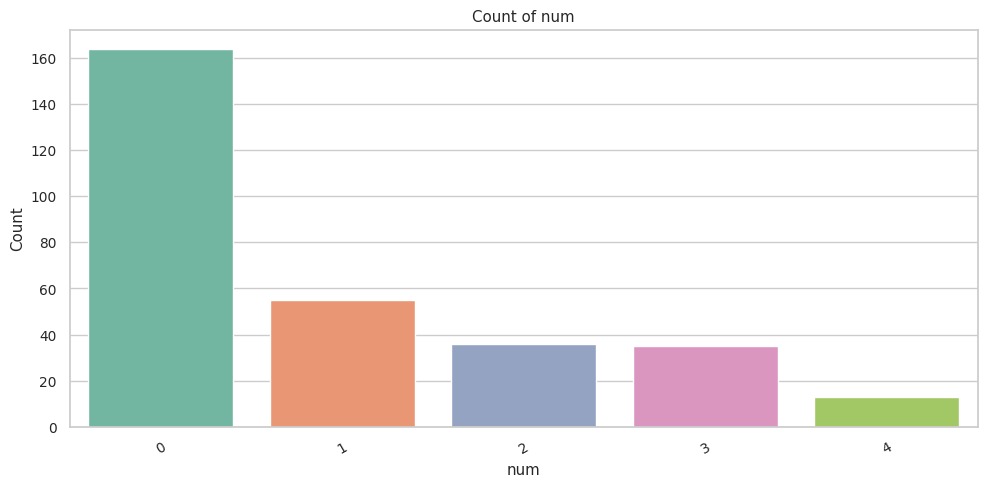

In [ ]:
plot_feature_distribution_categorical(heart_disease_df, 'num')

The target variable ranges from 0 to 4, where 0 indicates no heart disease and values 1 through 4 represent increasing levels of disease severity. However, most studies and implementations based on this dataset simplify the problem into a binary classification task. Specifically, all non-zero values (1–4) are grouped together and treated as “disease present,” while 0 remains “no disease.” This transformation is widely adopted because the dataset is relatively small and the higher severity classes contain very few samples, which makes multi-class modeling unstable and prone to imbalance. Moreover, for most practical and clinical purposes, the key question is whether a patient has heart disease at all, rather than predicting the precise severity level. Converting the target variable to binary form therefore improves model reliability, simplifies interpretation, and aligns with the primary goal of identifying the presence of heart disease, which is especially relevant for fairness and counterfactual analysis.

In [ ]:
# Collapse multi-class target into binary
heart_disease_df['HasHeartDisease'] = heart_disease_df['num'].apply(lambda x: 1 if x > 0 else 0)
heart_disease_df.drop(columns=['num'], inplace=True)
heart_disease_df['HasHeartDisease'].unique()

array([0, 1])

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


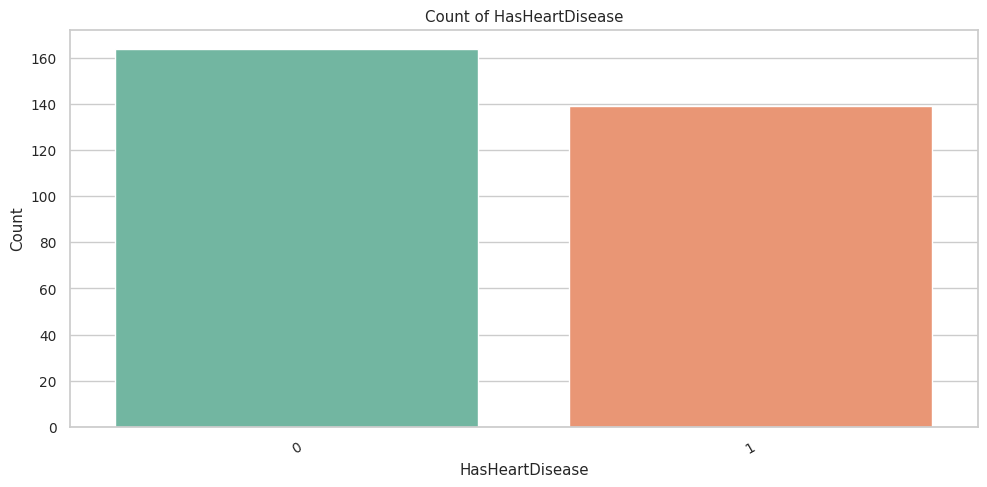

In [ ]:
plot_feature_distribution_categorical(heart_disease_df, 'HasHeartDisease')

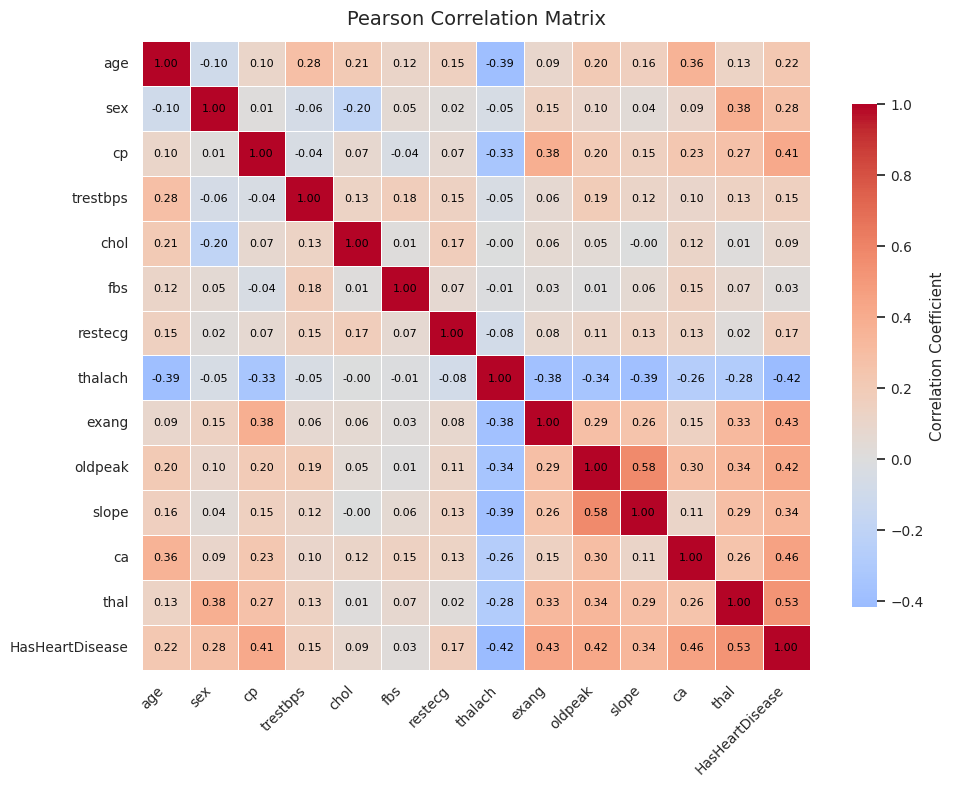

In [ ]:
plot_correlation_matrix(heart_disease_df)

* **Strongest correlations with the target (`HasHeartDisease`):**

  * **thal (0.53)** → Indicates that thalassemia test results are strongly related to heart disease presence.
  * **ca (0.46)** → The number of major vessels visible via fluoroscopy is an important diagnostic indicator.
  * **exang (0.43)** → Exercise-induced angina is positively linked to heart disease, as expected.
  * **cp (0.41)** → Certain types of chest pain are more common in patients with heart disease.

* **Strong negative correlation:**

  * **thalach (–0.42)** → Maximum heart rate achieved is inversely related to disease risk; lower heart rates during exercise are associated with higher likelihood of heart disease.

* **Moderate or weak correlations:**

  * Features such as **age**, **chol**, and **restecg** show low correlation values, suggesting that their effects might be non-linear or only become significant when interacting with other variables.



### **Categorical Features**

In [ ]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
for feature in categorical_features:
    heart_disease_df[feature] = heart_disease_df[feature].astype('object')

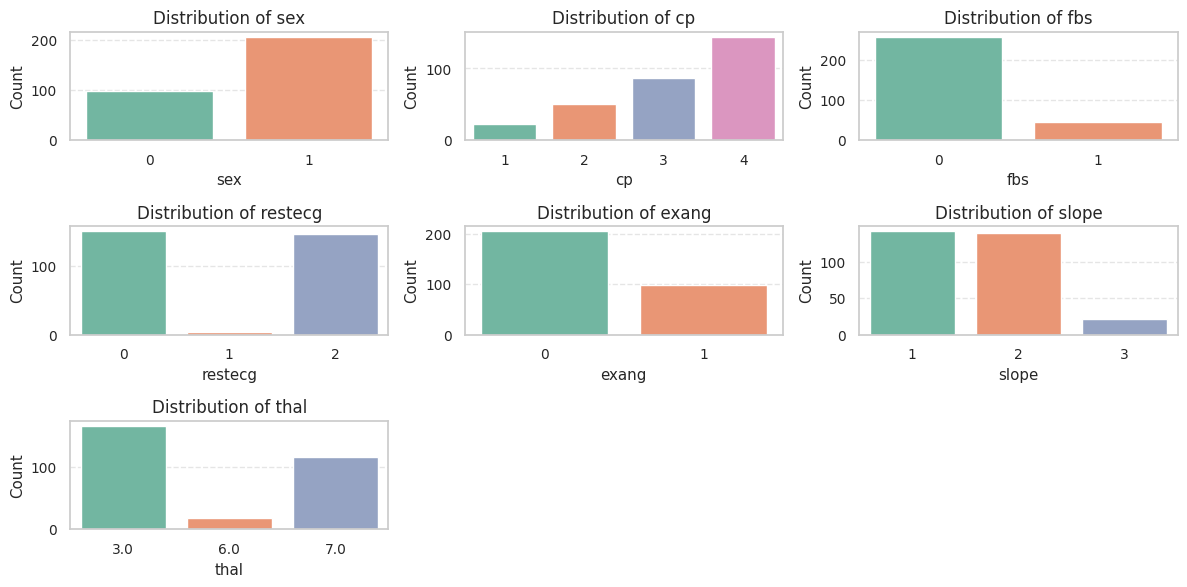

In [ ]:
plot_feature_distributions(heart_disease_df, categorical_features, figsize=(12,2))

The visualizations above show the distribution of several categorical features in the **Heart Disease dataset**, providing an overview of how each variable is represented among patients and how balanced the data is across feature categories.

* **Sex:** There is a noticeable imbalance, with a higher number of male patients (`1`) compared to female patients (`0`). This imbalance is important to keep in mind when studying gender fairness, as it might influence model bias and predictions.
* **Chest Pain Type (cp):** Most patients fall into the category `4` (asymptomatic), followed by categories `3` and `2`. Only a small portion experiences `typical angina (1)`. This skew suggests that the dataset includes many patients without clear chest pain symptoms, which might affect disease prediction.
* **Fasting Blood Sugar (fbs):** The majority of individuals have `fbs = 0`, meaning their fasting blood sugar is not above 120 mg/dl. This shows that high blood sugar is less common in the sample.
* **Resting Electrocardiographic Results (restecg):** Most patients have normal (`0`) or left ventricular hypertrophy (`2`) ECG readings, while abnormalities (`1`) are rare.
* **Exercise-Induced Angina (exang):** Most patients do not experience exercise-induced angina (`0`), although a significant group does (`1`).
* **Slope of the ST Segment (slope):** The distribution shows a predominance of `1` and `2` (upsloping or flat), with few cases of `3` (downsloping).
* **Thalassemia (thal):** The dataset is dominated by values `3` (normal) and `7` (reversible defect), while `6` (fixed defect) occurs less frequently, indicating class imbalance within this variable as well.

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=assoc_df['Cramér_V'], y=assoc_df.index, palette='viridis')


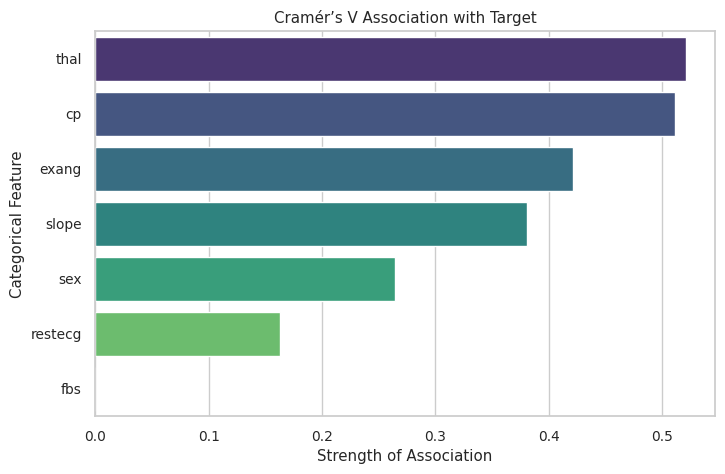

Cramér_V
thal     0.520525
cp       0.510832
exang    0.421617
slope    0.380738
sex      0.263945
restecg  0.163215
fbs      0.000000

In [ ]:
assoc_df = categorical_assoc_with_target(heart_disease_df, categorical_features, 'HasHeartDisease')
assoc_df

Using **Cramér’s V** to assess the association between categorical features and the target variable (`HasHeartDisease`), I observe the following:

* The features **`thal`**, **`cp`**, and **`exang`** stand out as the **most informative** categorical predictors for heart disease.
* Features like **`sex`** and **`slope`** have **moderate importance**, indicating potential interactions but not strong standalone signals.
* **`fbs`** may be dropped or deprioritized in modeling due to its lack of association.


I will map out the sex for better understanding.
- 1: Male
- 0: Female

In [ ]:
sex_mapping = {1: 'male', 0: 'female'}
heart_disease_df['sex_str'] = heart_disease_df['sex'].map(sex_mapping)

Since **sex** is a sensitive attribute that could introduce bias into the model, I will use the **DataAuditor** library to further investigate potential fairness issues and assess how this feature influences predictions.


In [ ]:
heart_disease_df['HasHeartDisease'] = heart_disease_df['HasHeartDisease'].astype('object')
heart_disease_profile = DataProfiler(df=heart_disease_df, target='HasHeartDisease')
heart_disease_profile.print_report()

n_samples: 303
n_features: 15
target: HasHeartDisease
num_cols: ['age', 'ca', 'chol', 'oldpeak', 'thalach', 'trestbps']
cat_cols: ['cp', 'exang', 'fbs', 'restecg', 'sex', 'sex_str', 'slope', 'thal']
mv_cols: ['ca', 'thal']
mv_percentage: 0.13
duplicate_rows: 0
target_distribution: {0: 0.54, 1: 0.46}


In [ ]:
heart_disease_engine = FairnessEngine(df=heart_disease_df, target='HasHeartDisease', sensitive_features=['sex'])

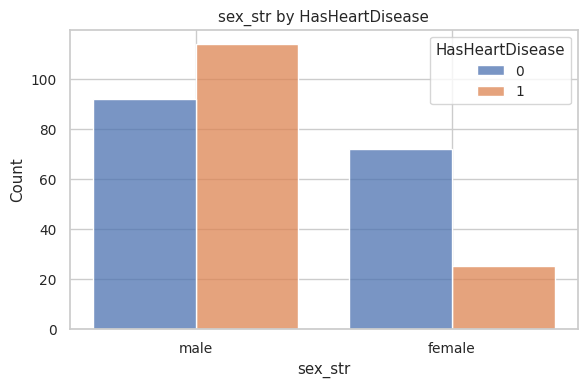

In [ ]:
heart_disease_profile.plot_mult_histogram(col_names=['sex_str'], cols=1, hue='HasHeartDisease')

In [ ]:
heart_disease_engine.target_rate_by_group_table(group='sex')

sex                  0      1
HasHeartDisease              
0                23.76  30.36
1                 8.25  37.62

**Gender and Heart Disease**

Heart disease affects both men and women, but **men tend to develop it earlier**, while women experience a **sharp increase in risk after menopause**. Differences in symptoms, hormonal protection, and medical treatment contribute to this gap. Since **sex is a sensitive feature**, it is important to examine whether predictive models show **gender-related bias** or unequal predictive behavior.



References

Centers for Disease Control and Prevention. (2023). Heart Disease Facts. U.S. Department of Health and Human Services. https://www.cdc.gov/heartdisease/facts.htm

Virani, S. S., Alonso, A., Aparicio, H. J., et al. (2021). Heart Disease and Stroke Statistics—2021 Update: A Report From the American Heart Association. Circulation, 143(8), e254–e743.

World Health Organization. (2021). Global Health Estimates 2021: Disease burden by Cause, Age, Sex, by Country and by Region, 2000–2019. Geneva: WHO.

<Axes: xlabel='age_bin', ylabel='HasHeartDisease'>

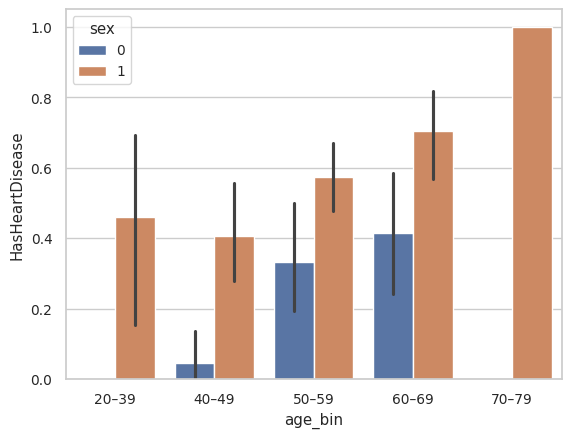

In [ ]:
heart_disease_df['age_bin'] = pd.cut(heart_disease_df['age'], bins=[20, 40, 50, 60, 70, 80], labels=['20–39','40–49','50–59','60–69','70–79'])
sns.barplot(data=heart_disease_df, x='age_bin', y='HasHeartDisease', hue='sex')


/tmp/ipython-input-3457562260.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heart_disease_df.groupby(['sex', 'age_group'])['HasHeartDisease']


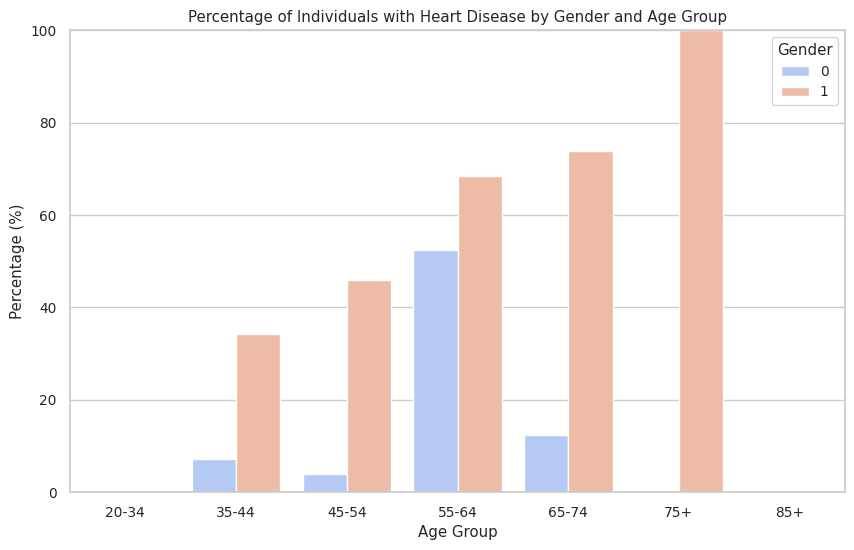

In [ ]:
# Define age bins
bins = [20, 35, 45, 55, 65, 75, 85, 120]
labels = ['20-34', '35-44', '45-54', '55-64', '65-74', '75+', '85+']
heart_disease_df = heart_disease_df.copy()
heart_disease_df['age_group'] = pd.cut(heart_disease_df['age'], bins=bins, labels=labels, right=False)

# Convert 'HasHeartDisease' to integer type
heart_disease_df['HasHeartDisease'] = heart_disease_df['HasHeartDisease'].astype(int)

# Compute percentage of heart disease within each gender and age group
stats = (
    heart_disease_df.groupby(['sex', 'age_group'])['HasHeartDisease']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)

# Keep only the rows for heart disease cases
stats = stats[stats['HasHeartDisease'] == 1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=stats, x='age_group', y='percentage', hue='sex', palette='coolwarm')
plt.title('Percentage of Individuals with Heart Disease by Gender and Age Group')
plt.ylabel('Percentage (%)')
plt.xlabel('Age Group')
plt.ylim(0, 100)
plt.legend(title='Gender')
plt.show()


* **General trend:**
  The percentage of individuals with heart disease increases with age — which aligns strongly with medical evidence that cardiovascular risk grows over time.

* **Gender differences:**

  * Across **almost all age groups**, **males (1)** show a higher percentage of heart disease compared to **females (0)**.
  * The difference is particularly large in **middle age (45–64)** — men in this range have roughly **1.5–2× higher prevalence**.
  * In older groups (65–74 and above), the difference narrows slightly — this reflects the real-world pattern where women’s risk rises sharply after menopause.

* **Younger groups (20–44):**
  Heart disease is rare for both genders, but still slightly more common in men.
  

These patterns are consistent with **epidemiological findings**:

* Men tend to develop heart disease about **7–10 years earlier** than women.
* **Estrogen** provides some cardiovascular protection to pre-menopausal women.
* After menopause, women’s risk catches up, leading to similar or even higher rates in the 70+ group.


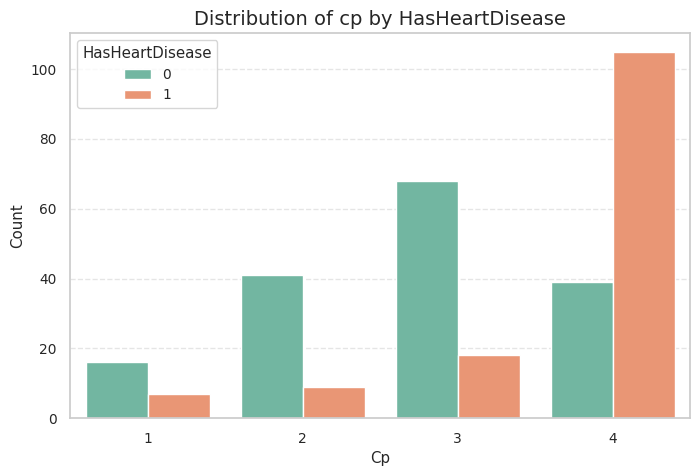

In [ ]:
compare_categorical_distribution(heart_disease_df, 'cp', 'HasHeartDisease')

- This distribution aligns with clinical understanding:
  - Patients **without heart disease** typically report **typical or atypical angina** during exertion.
  - Patients **with heart disease** often present **asymptomatic or vague pain (type 4)**, complicating early detection.
- Therefore, **`cp` is a highly discriminative feature**, showing a strong relationship with the target variable (`HasHeartDisease`).

### **Discrete Features**

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


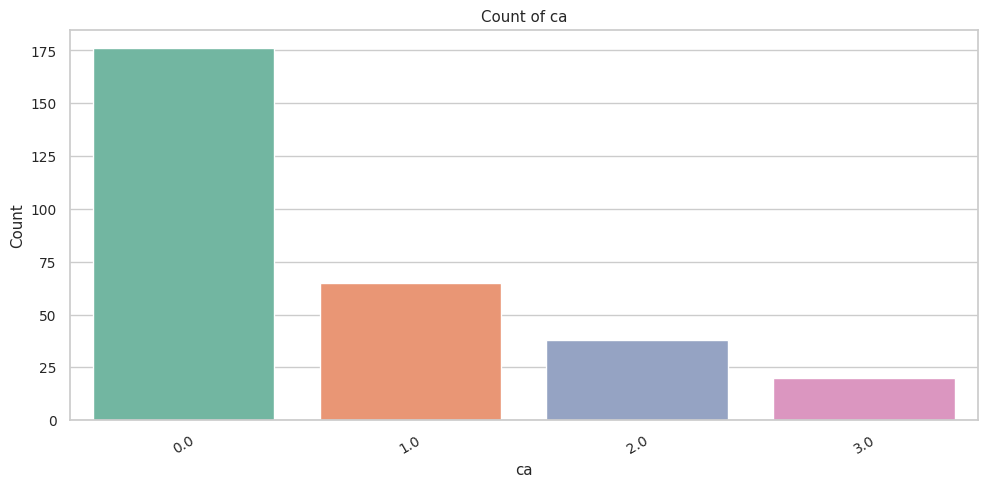

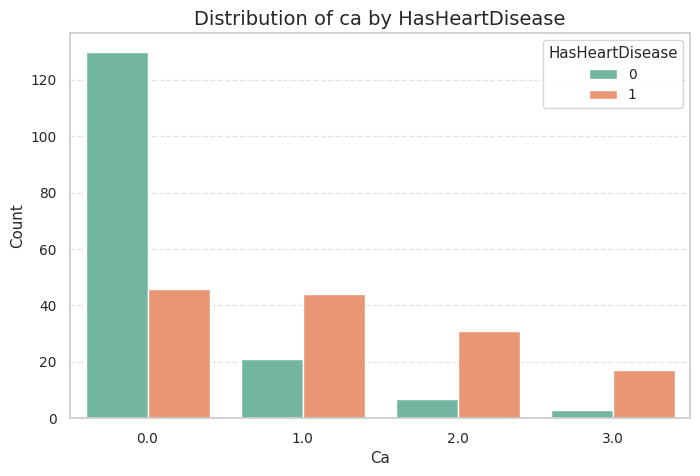

In [ ]:
plot_feature_distribution_categorical(heart_disease_df, 'ca')
compare_categorical_distribution(heart_disease_df, 'ca', 'HasHeartDisease')

### **Continuous Features**

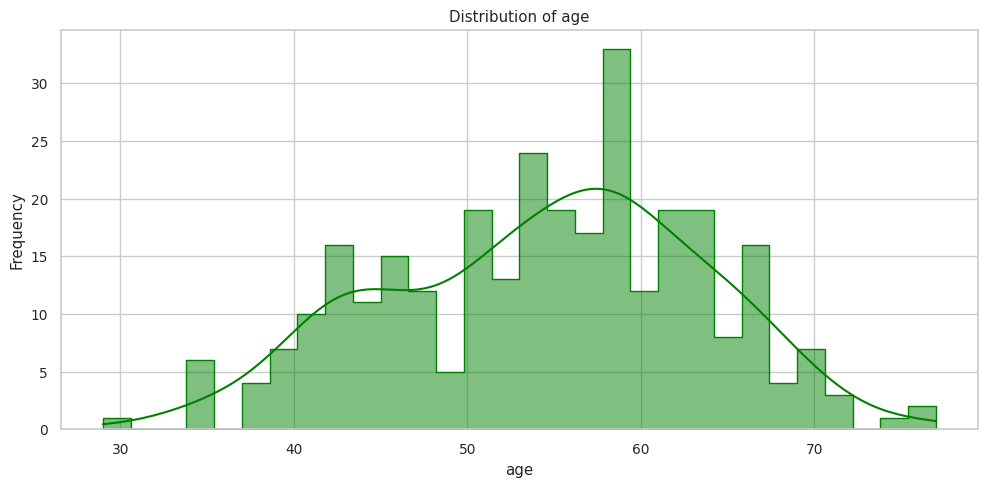

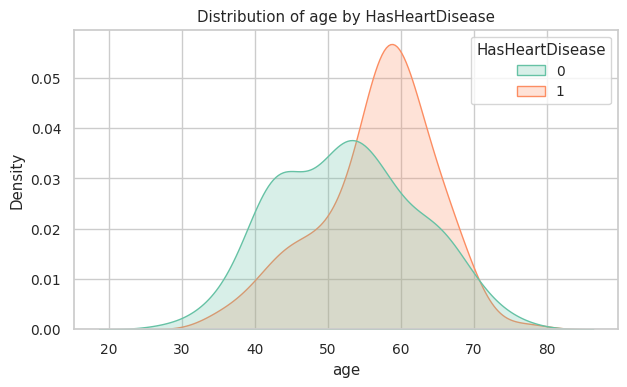

In [ ]:
plot_feature_distribution_numeric(heart_disease_df, 'age')
plot_numerical_distributions(heart_disease_df, ['age'])

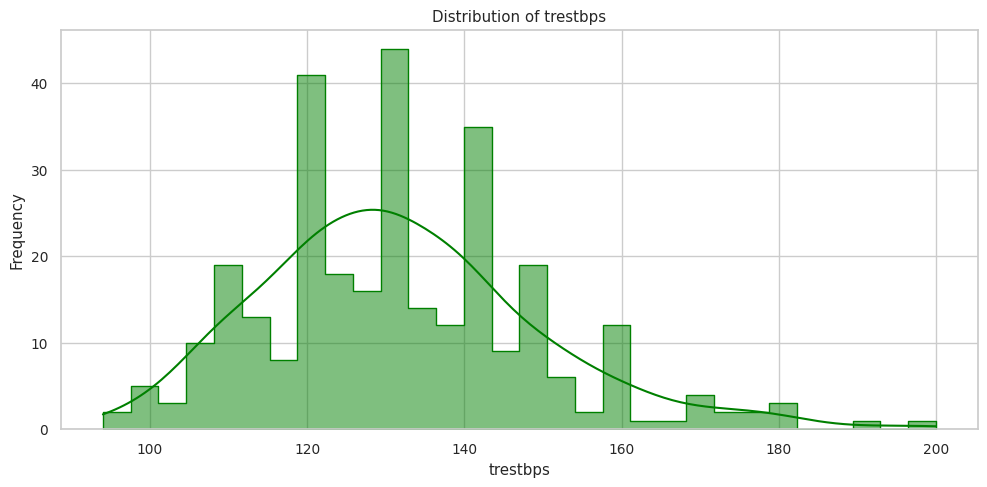

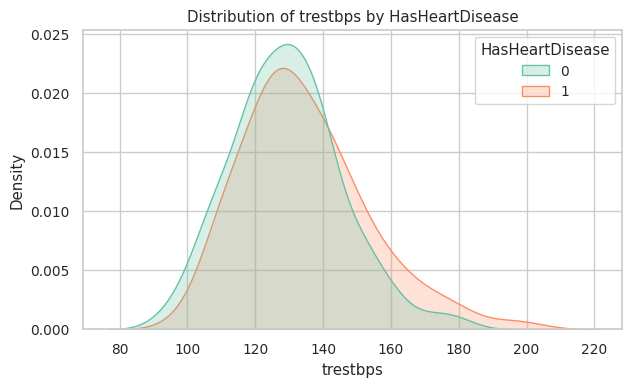

In [ ]:
plot_feature_distribution_numeric(heart_disease_df, 'trestbps')
plot_numerical_distributions(heart_disease_df, ['trestbps'])

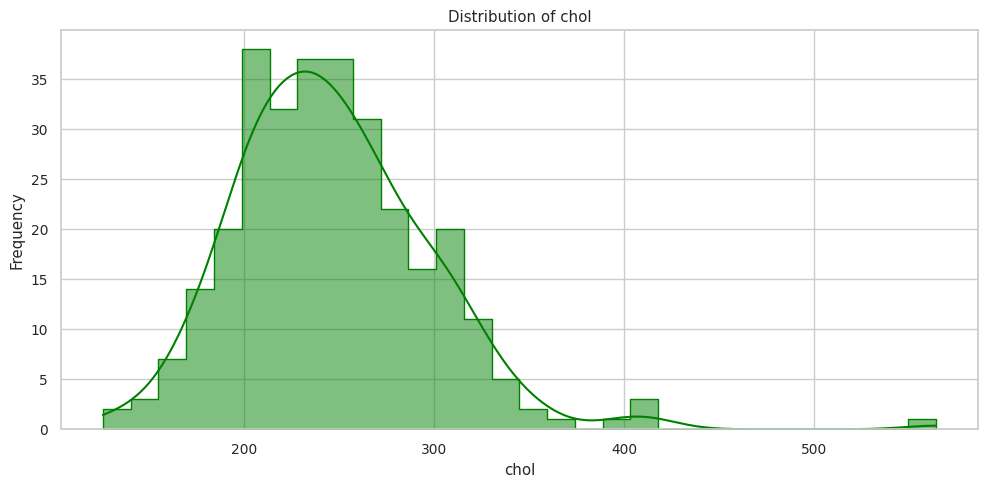

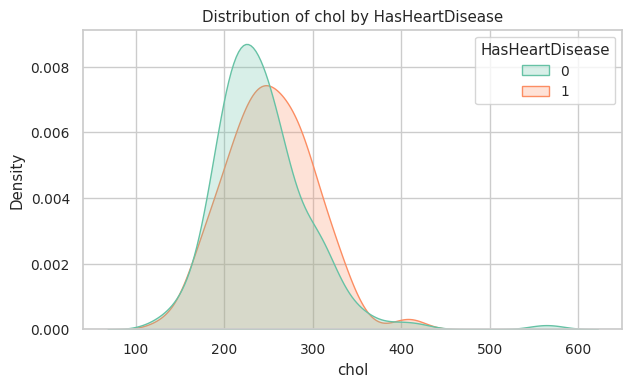

In [ ]:
plot_feature_distribution_numeric(heart_disease_df, 'chol')
plot_numerical_distributions(heart_disease_df, ['chol'])

---
## 3. Preprocessing
---

**Missing Values**

In [ ]:
#check missing values
heart_disease_df.isnull().sum()

age                0
sex                0
cp                 0
trestbps           0
chol               0
fbs                0
restecg            0
thalach            0
exang              0
oldpeak            0
slope              0
ca                 4
thal               2
HasHeartDisease    0
sex_str            0
age_bin            0
age_group          0
dtype: int64

In [ ]:
#fill na's
heart_disease_df['thal'] = heart_disease_df['thal'].fillna(heart_disease_df['thal'].mode()[0])
heart_disease_df['ca'] = heart_disease_df['ca'].fillna(heart_disease_df['ca'].mode()[0])

heart_disease_df.isnull().sum().sum()

/tmp/ipython-input-2636946434.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heart_disease_df['thal'] = heart_disease_df['thal'].fillna(heart_disease_df['thal'].mode()[0])


np.int64(0)

**Fix Data Types**

In [ ]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'HasHeartDisease']
for col in categorical_cols:
    heart_disease_df[col] = heart_disease_df[col].astype('category')
    print(f'Unique values in {col}: {heart_disease_df[col].unique()}')

Unique values in sex: [1, 0]
Categories (2, int64): [0, 1]
Unique values in cp: [1, 4, 3, 2]
Categories (4, int64): [1, 2, 3, 4]
Unique values in fbs: [1, 0]
Categories (2, int64): [0, 1]
Unique values in restecg: [2, 0, 1]
Categories (3, int64): [0, 1, 2]
Unique values in exang: [0, 1]
Categories (2, int64): [0, 1]
Unique values in slope: [3, 2, 1]
Categories (3, int64): [1, 2, 3]
Unique values in thal: [6.0, 3.0, 7.0]
Categories (3, float64): [3.0, 6.0, 7.0]
Unique values in HasHeartDisease: [0, 1]
Categories (2, int64): [0, 1]


**Encoding of Categorical Variables**

In [ ]:
# Label encode binary categorical columns
binary_cols = ['sex', 'fbs', 'exang', 'HasHeartDisease']
encoder = LabelEncoder()
for col in binary_cols:
    heart_disease_df[col] = encoder.fit_transform(heart_disease_df[col])

# One-hot encode multi-category features
heart_disease_df = pd.get_dummies(heart_disease_df, columns=['thal', 'cp', 'restecg', 'slope'], drop_first=True)


**Numerical Features Scaling**

In [ ]:
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
scaler = StandardScaler()
heart_disease_df[num_cols] = scaler.fit_transform(heart_disease_df[num_cols])


In [ ]:
heart_disease_df

age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0    0.948726    1  0.757525 -0.264900    1  0.017197      0  1.087338   
1    1.392002    1  1.611220  0.760415    0 -1.821905      1  0.397182   
2    1.392002    1 -0.665300 -0.342283    0 -0.902354      1  1.346147   
3   -1.932564    1 -0.096170  0.063974    0  1.637359      0  2.122573   
4   -1.489288    0 -0.096170 -0.825922    0  0.980537      0  0.310912   
..        ...  ...       ...       ...  ...       ...    ...       ...   
298 -1.046013    1 -1.234430  0.334813    0 -0.770990      0  0.138373   
299  1.502821    1  0.700612 -1.038723    1 -0.376896      0  2.036303   
300  0.283813    1 -0.096170 -2.238149    0 -1.515388      1  0.138373   
301  0.283813    0 -0.096170 -0.206864    0  1.068113      0 -0.896862   
302 -1.821745    1  0.359134 -1.386944    0  1.024325      0 -0.896862   

           ca  HasHeartDisease  ... age_group thal_6.0 thal_7.0   cp_2   cp_3  \
0   -0.711131                0  ...     55-64     True    False  False  False   
1    2.504881                1  ...     65-74    False    False  False  False   
2    1.432877                1  ...     65-74    False     True  False  False   
3   -0.711131                0  ...     35-44    False    False  False   True   
4   -0.711131                0  ...     35-44    False    False   True  False   
..        ...              ...  ...       ...      ...      ...    ...    ...   
298 -0.711131                1  ...     45-54    False     True  False  False   
299  1.432877                1  ...     65-74    False     True  False  False   
300  0.360873                1  ...     55-64    False     True  False  False   
301  0.360873                1  ...     55-64    False    False   True  False   
302 -0.711131                0  ...     35-44    False    False  False   True   

      cp_4  restecg_1  restecg_2  slope_2  slope_3  
0    False      False       True    False     True  
1     True      False       True     True    False  
2     True      False       True     True    False  
3    False      False      False    False     True  
4    False      False       True    False    False  
..     ...        ...        ...      ...      ...  
298  False      False      False     True    False  
299   True      False      False     True    False  
300   True      False      False     True    False  
301  False      False       True     True    False  
302  False      False      False    False    False  

[303 rows x 22 columns]

In [ ]:
heart_disease_df.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'ca', 'HasHeartDisease', 'sex_str', 'age_bin', 'age_group', 'thal_6.0',
       'thal_7.0', 'cp_2', 'cp_3', 'cp_4', 'restecg_1', 'restecg_2', 'slope_2',
       'slope_3'],
      dtype='object')

In [ ]:
heart_disease_df.drop(columns=['sex_str', 'age_bin', 'age_group'],inplace=True)

In [ ]:
#save df
heart_disease_df.to_csv('./datasets/heart_disease_preprocessed.csv', index=False)

---
## 4. Modelling
---

In [ ]:
heart_disease_df = pd.read_csv('./datasets/heart_disease_preprocessed.csv')
heart_disease_df

age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0    0.948726    1  0.757525 -0.264900    1  0.017197      0  1.087338   
1    1.392002    1  1.611220  0.760415    0 -1.821905      1  0.397182   
2    1.392002    1 -0.665300 -0.342283    0 -0.902354      1  1.346147   
3   -1.932564    1 -0.096170  0.063974    0  1.637359      0  2.122573   
4   -1.489288    0 -0.096170 -0.825922    0  0.980537      0  0.310912   
..        ...  ...       ...       ...  ...       ...    ...       ...   
298 -1.046013    1 -1.234430  0.334813    0 -0.770990      0  0.138373   
299  1.502821    1  0.700612 -1.038723    1 -0.376896      0  2.036303   
300  0.283813    1 -0.096170 -2.238149    0 -1.515388      1  0.138373   
301  0.283813    0 -0.096170 -0.206864    0  1.068113      0 -0.896862   
302 -1.821745    1  0.359134 -1.386944    0  1.024325      0 -0.896862   

           ca  HasHeartDisease  thal_6.0  thal_7.0   cp_2   cp_3   cp_4  \
0   -0.711131                0      True     False  False  False  False   
1    2.504881                1     False     False  False  False   True   
2    1.432877                1     False      True  False  False   True   
3   -0.711131                0     False     False  False   True  False   
4   -0.711131                0     False     False   True  False  False   
..        ...              ...       ...       ...    ...    ...    ...   
298 -0.711131                1     False      True  False  False  False   
299  1.432877                1     False      True  False  False   True   
300  0.360873                1     False      True  False  False   True   
301  0.360873                1     False     False   True  False  False   
302 -0.711131                0     False     False  False   True  False   

     restecg_1  restecg_2  slope_2  slope_3  
0        False       True    False     True  
1        False       True     True    False  
2        False       True     True    False  
3        False      False    False     True  
4        False       True    False    False  
..         ...        ...      ...      ...  
298      False      False     True    False  
299      False      False     True    False  
300      False      False     True    False  
301      False       True     True    False  
302      False      False    False    False  

[303 rows x 19 columns]

In [ ]:
X = heart_disease_df.drop(columns=['HasHeartDisease'])
y = heart_disease_df['HasHeartDisease'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
y_pred_results = {}
y_proba_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred_results[name] = y_pred
    y_proba_results[name] = y_proba

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "true_positive_rate": true_positive_rate(y_test, y_pred),
        "false_positive_rate": false_positive_rate(y_test, y_pred),
        "selection_rate": selection_rate(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.sort_values(by='ROC_AUC', ascending=False)
results_df


Accuracy        F1   ROC_AUC  true_positive_rate  \
SVM                  0.934426  0.931034  0.967532            0.964286   
Random Forest        0.918033  0.915254  0.958874            0.964286   
Logistic Regression  0.852459  0.847458  0.956710            0.892857   
Gradient Boosting    0.868852  0.862069  0.935065            0.892857   

                     false_positive_rate  selection_rate  
SVM                             0.090909        0.491803  
Random Forest                   0.121212        0.508197  
Logistic Regression             0.181818        0.508197  
Gradient Boosting               0.151515        0.491803

- **SVM** achieved the best overall performance, with the highest accuracy, F1-score, and ROC-AUC.
This suggests that the decision boundary found by the SVM captures the non-linear relationships in the heart disease data very effectively.

- **Random Forest** follows closely behind, with very similar performance but slightly lower scores. This model often provides better interpretability (e.g., feature importances), making it a good candidate for further fairness and explainability analysis.

- **Gradient Boosting** performs moderately well, with solid predictive power but slightly weaker sensitivity to minority cases (lower F1).
It may benefit from fine-tuning hyperparameters (e.g., learning rate, tree depth).

- **Logistic Regression**, as a linear model, performs reasonably well but underperforms compared to the others, confirming that non-linear patterns are important in this dataset.

## 5. Counterfactuals - DiCE

In [69]:
def find_counterfactuals(model, df, X_test, sex):
    # Wrap your trained Random Forest model
    model_dice = dice_ml.Model(model=model, backend='sklearn', model_type='classifier')

    # Define the data interface
    data_dice = dice_ml.Data(
        dataframe=df, # Use the preprocessed dataframe
        continuous_features=['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'],
        categorical_features=['sex', 'cp_2', 'cp_3', 'cp_4', 'fbs', 'restecg_1', 'restecg_2', 'exang', 'slope_2', 'slope_3', 'thal_6.0', 'thal_7.0'], # These need to be the one-hot encoded categorical features
        outcome_name='HasHeartDisease'
    )

    # Create the DiCE explainer
    exp = Dice(data_dice, model_dice, method='random')

    # Select only male samples
    samples = X_test[X_test['sex'] == sex] # Use the numerical representation of sex

    cf_results = []

    for i, row in samples.iterrows():
        query = pd.DataFrame([row])
        try:
            # Generate a counterfactual changing only the 'sex' feature
            cf = exp.generate_counterfactuals(
                query,
                total_CFs=1,
                desired_class="opposite",
                features_to_vary=['sex']
            )

            result_df = cf.cf_examples_list[0].final_cfs_df
            cf_results.append(result_df)

        except Exception as e:
            print(f"Skipped sample {i}: {e}")

    # Combine and inspect all counterfactuals
    if len(cf_results) > 0:
        all_cfs = pd.concat(cf_results, ignore_index=True)
        return all_cfs
    else:
        print("No counterfactuals found")
        return None

### CHECK THIS - MULTIPLE DIFFERENT SEX IN RESULTS

In [71]:
find_counterfactuals(models['Random Forest'], heart_disease_df, X_test, sex=1)


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 245: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 15: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


Skipped sample 54: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Skipped sample 141: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters...

100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


 ; total time taken: 00 min 00 sec
Skipped sample 236: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 302: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 33: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 8: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 59: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 155: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 219: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Skipped sample 290: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 285: No counterfactuals found for any of the query points! Kindly check your configuration.



100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 1: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 139: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 179: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 98: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 118: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Skipped sample 140: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 247: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Skipped sample 146: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 2: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 186: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 265: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 5: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 99: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 84: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 105: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 300: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 270: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 13: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 100: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 131: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 215: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 251: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 264: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 122: No counterfactuals found for any of the query points! Kindly check your configuration.


age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0  1.281183    1  1.611220 -0.013408    0 -1.296447      1 -0.896862   
1  1.059545    0 -0.380735  1.205363    0 -0.814778      1  0.655990   
2 -1.046013    0 -1.234430  0.334813    0 -0.770990      0  0.138373   
3 -1.156832    1 -1.234430 -0.961341    0  1.199478      0 -0.896862   
4 -0.270281    1 -1.120604 -0.322937    0  0.455079      0 -0.896862   

         ca  thal_6.0  thal_7.0   cp_2   cp_3   cp_4  restecg_1  restecg_2  \
0  2.504881      True     False   True  False  False      False      False   
1 -0.711131     False      True  False   True  False      False      False   
2 -0.711131     False      True  False  False  False      False      False   
3  0.360873     False     False  False  False   True      False       True   
4  0.360873     False     False  False  False   True      False      False   

   slope_2  slope_3  HasHeartDisease  
0     True    False                0  
1     True    False                0  
2     True    False                0  
3    False    False                0  
4    False    False                0

Let's try to explain this

In [ ]:
display_fairness_metrics(X_test, y_test, y_pred_results['Random Forest'])

     accuracy  selection_rate       tpr  fpr
sex                                         
0    1.000000        0.350000  1.000000  0.0
1    0.878049        0.585366  0.952381  0.2

# Fairness Summary:
Demographic Parity Difference: 0.2354
Equalized Odds Difference: 0.2000


**Demographic Parity Difference (DPD)**:

Measures how prediction rates differ across genders.

- 0 = perfectly fair;

- 0.1 often considered a potential bias (depending on context).

**Equalized Odds Difference (EOD)**:

Compares true positive and false positive rates between genders.

If high → one gender is systematically over/under-predicted.

 **Accuracy by gender**

| Sex            | Accuracy | Interpretation                                                                                                                        |
| -------------- | -------- | ------------------------------------------------------------------------------------------------------------------------------------- |
| **0 (female)** | **1.00** | Perfect classification. All predictions for women are correct. This might also signal **overfitting** or **too few female samples**. |
| **1 (male)**   | **0.88** | The model makes more mistakes on men than women.                                                                                      |

---

**Selection rate**

| Sex        | Selection Rate | Meaning                                                |
| ---------- | -------------- | ------------------------------------------------------ |
| 0 (female) | 0.35           | Only 35% of women are predicted to have heart disease. |
| 1 (male)   | 0.59           | 59% of men are predicted to have heart disease.        |

That’s a **large gap (≈24%)** — men are much more likely to be classified as having heart disease.
This may reflect **historical bias in data**, since men often have higher observed heart disease prevalence.

---

**True Positive Rate (TPR)**

| Sex    | TPR  | Meaning                                                             |
| ------ | ---- | ------------------------------------------------------------------- |
| Female | 1.00 | All true cases of heart disease among women are correctly detected. |
| Male   | 0.95 | The model slightly misses some positive male cases.                 |

The model detects nearly all positive cases for both genders.

---

**False Positive Rate (FPR)**

| Sex    | FPR  | Meaning                                                   |
| ------ | ---- | --------------------------------------------------------- |
| Female | 0.00 | No false alarms. All negatives were correctly predicted. |
| Male   | 0.20 | 20% of men without heart disease are incorrectly flagged. |

This indicates a **bias toward over-predicting disease in men**.

---

**Fairness Metrics**

| Metric                                    | Value                                                                          | Interpretation |
| ----------------------------------------- | ------------------------------------------------------------------------------ | -------------- |
| **Demographic Parity Difference (0.235)** | Significant gap: model predicts positives for men much more often than women. |                |
| **Equalized Odds Difference (0.20)**      | Noticeable disparity in error rates between men and women (mainly due to FPR). |                |


---


! At first glance, this seems backwards: usually minority groups get **worse** performance. But it’s actually plausible, depending on **class distribution and label balance within each gender**.

---

**Possible explanations**

1.

* **Women with disease:** 8.25 / 32.01 ≈ 25.8%

* **Women without disease:** 23.76 / 32.01 ≈ 74.2%

* **Men with disease:** 37.62 / 67.98 ≈ 55.3%

* **Men without disease:** 30.36 / 67.98 ≈ 44.7%

Key insight: **Most women (~74%) are healthy**, while men are almost balanced (~55% diseased, 45% healthy).

---
**Implications for model accuracy:**

* If the model predicts **“no disease” for all women**, it would already get ~74% correct.

* With proper feature learning, the model can reach **100% accuracy for women** because:

  * The women subgroup is smaller → easier to “memorize” or learn patterns.
  * The disease prevalence is lower → fewer positive cases to misclassify.

* For men, accuracy is lower (~88%) because:

  * Classes are almost balanced → harder to predict correctly.
  * The model has to learn subtler differences between diseased vs. healthy men.

---


2. Feature separability

* Features might be more predictive for women than for men.
* Example: cholesterol, age, or blood pressure patterns might **correlate more strongly with disease for women** than for men in your dataset.
* This gives the model an easier time classifying women correctly, even though they are under-represented.

---

3. Sampling and train-test split

* If the train-test split is random, and the women sample is small (minority), the **test set might only contain “easy” examples**.
* This can inflate minority accuracy metrics.


In [ ]:
display_fairness_metrics(X_test, y_test, y_pred_results['SVM'])

     accuracy  selection_rate       tpr   fpr
sex                                          
0    1.000000        0.350000  1.000000  0.00
1    0.902439        0.560976  0.952381  0.15

# Fairness Summary:
Demographic Parity Difference: 0.2110
Equalized Odds Difference: 0.1500


In [ ]:
display_fairness_metrics(X_test, y_test, y_pred_results['Logistic Regression'])

     accuracy  selection_rate       tpr  fpr
sex                                         
0    0.950000        0.300000  0.857143  0.0
1    0.804878        0.609756  0.904762  0.3

# Fairness Summary:
Demographic Parity Difference: 0.3098
Equalized Odds Difference: 0.3000


In [ ]:
display_fairness_metrics(X_test, y_test, y_pred_results['Gradient Boosting'])

     accuracy  selection_rate       tpr       fpr
sex                                              
0    0.900000        0.350000  0.857143  0.076923
1    0.853659        0.560976  0.904762  0.200000

# Fairness Summary:
Demographic Parity Difference: 0.2110
Equalized Odds Difference: 0.1231


Let's run SHAP per gender

In [ ]:
X_female = X_test[X_test['sex'] == 0]
X_male = X_test[X_test['sex'] == 1]

In [ ]:
explainer = shap.TreeExplainer(models['Random Forest'])

In [ ]:
shap_values_female = explainer.shap_values(X_female)
shap_values_male = explainer.shap_values(X_male)

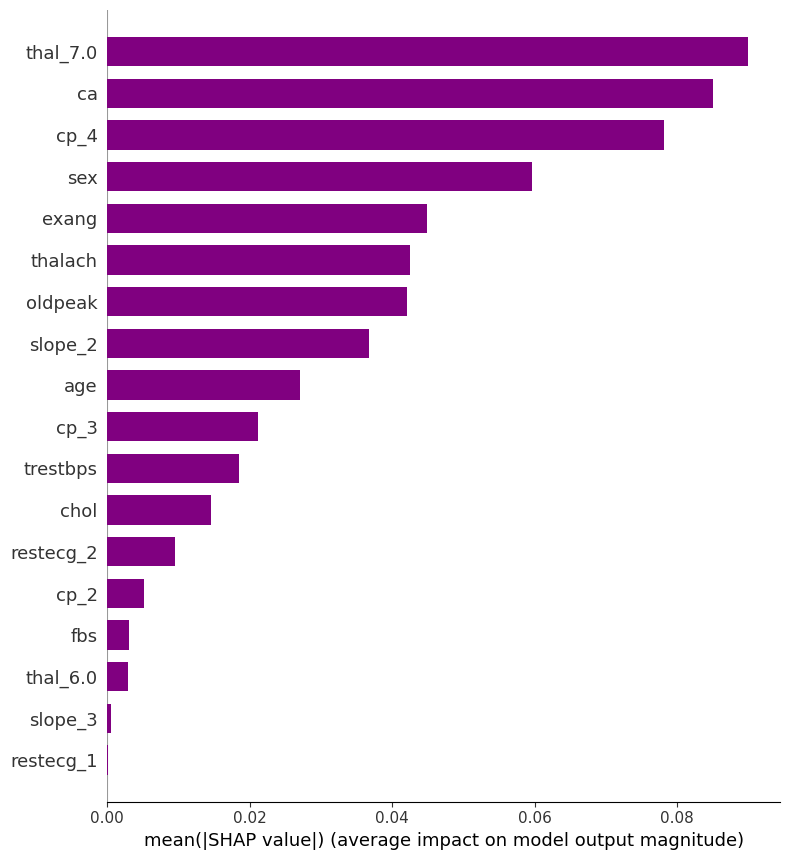

In [ ]:
# Top features for women
shap.summary_plot(shap_values_female[:,:,1], X_female, plot_type="bar", show=False, color='purple')

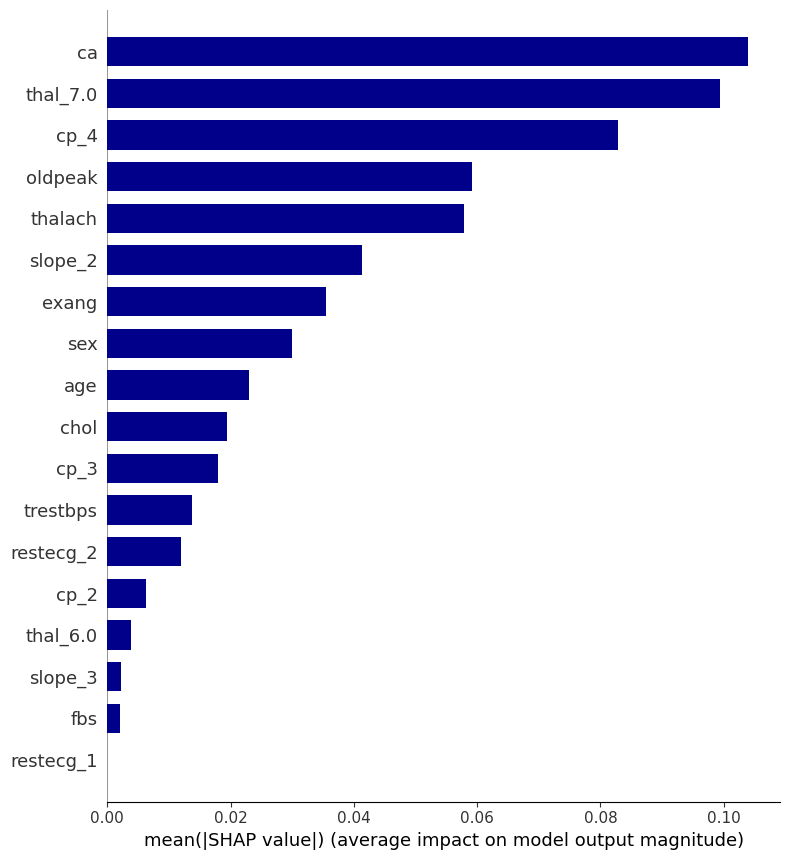

In [ ]:
# Top features for men
shap.summary_plot(shap_values_male[:,:,1], X_male, plot_type="bar", show=False, color='darkblue')

These SHAP plots show that the model relies on different features when predicting heart disease for men and women. For **women** (purple), the most influential features are categorical variables such as **thal_7.0**, **ca**, **cp_4**, and notably **sex** itself, suggesting that the model may have learned gender-specific shortcuts rather than genuine medical patterns — a likely result of the smaller number of female samples. In contrast, for **men** (blue), the model’s predictions are driven more by clinical indicators like **oldpeak**, **thalach**, and **slope_2**, reflecting a stronger dependence on physiological features. This divergence indicates that the model generalizes better for men but may be **overfitting or biased** in how it classifies women, contributing to the observed 100% accuracy for females and 88% for males.

---

Let's try a different approach for splitting the data:

## **Stratified split by both gender and disease**

This ensures each subset (train/test) keeps the same proportions of men/women with/without disease.

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create a stratification label combining sex and target
strat_col = X['sex'].astype(str) + "_" + y.astype(str)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, strat_col):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [67]:
#Sanity check
train_df = X_train.copy()
train_df['HasHeartDisease'] = y_train

test_df = X_test.copy()
test_df['HasHeartDisease'] = y_test

print("Train gender distribution:")
print(train_df['sex'].value_counts(normalize=True))
print("\nTest gender distribution:")
print(test_df['sex'].value_counts(normalize=True))

Train gender distribution:
sex
1    0.677686
0    0.322314
Name: proportion, dtype: float64

Test gender distribution:
sex
1    0.688525
0    0.311475
Name: proportion, dtype: float64


In [63]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}
y_pred_results = {}
y_proba_results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred_results[name] = y_pred
    y_proba_results[name] = y_proba

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "true_positive_rate": true_positive_rate(y_test, y_pred),
        "false_positive_rate": false_positive_rate(y_test, y_pred),
        "selection_rate": selection_rate(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.sort_values(by='ROC_AUC', ascending=False)
results_df


Accuracy        F1   ROC_AUC  true_positive_rate  \
Logistic Regression  0.868852  0.851852  0.967532            0.821429   
SVM                  0.901639  0.892857  0.936147            0.892857   
Random Forest        0.836066  0.814815  0.925325            0.785714   
Gradient Boosting    0.770492  0.758621  0.856061            0.785714   

                     false_positive_rate  selection_rate  
Logistic Regression             0.090909        0.426230  
SVM                             0.090909        0.459016  
Random Forest                   0.121212        0.426230  
Gradient Boosting               0.242424        0.491803

In [68]:
display_fairness_metrics(X_test, y_test, y_pred_results['Random Forest'])

     accuracy  selection_rate      tpr       fpr
sex                                             
0    0.842105        0.421053  1.00000  0.214286
1    0.833333        0.428571  0.73913  0.052632

# Fairness Summary:
Demographic Parity Difference: 0.0075
Equalized Odds Difference: 0.2609


Model performance metrics became more stable and aligned with expected benchmarks for the UCI Heart Disease dataset. This indicates that the previous anomalies—such as 100% accuracy for women—were primarily caused by uneven or unrepresentative data partitioning. With the corrected split, overall performance now ranges from approximately 0.77 to 0.90 accuracy across the evaluated models, with the SVM achieving the best results.

Focusing on fairness analysis for the Random Forest classifier, the results show a nuanced picture. The **Demographic Parity Difference (0.0075)** is extremely small, indicating that the model predicts heart disease at nearly equal rates for men and women (selection rates of 0.421 for females and 0.429 for males). This suggests that the model is not biased in terms of the overall likelihood of assigning a positive prediction to either gender.

However, the **Equalized Odds metrics reveal a substantial discrepancy**. Women exhibit a **true positive rate (TPR) of 1.00**, meaning the model correctly identifies all cases of heart disease in female patients, while the TPR for men is significantly lower at **0.739**, indicating many missed male cases. Conversely, the **false positive rate (FPR)** is higher for women (0.214) than for men (0.053), implying that women without heart disease are more often incorrectly flagged. These differences in TPR and FPR contribute to an **Equalized Odds Difference of 0.2609**, signaling that the model’s error rates are unevenly distributed across genders.

In summary, although the model now achieves balanced selection rates across genders, it still displays **systematic disparities in error rates**, particularly over-sensitizing predictions for women and under-detecting disease in men. This pattern suggests that additional mitigation strategies—such as reweighting, targeted resampling, or post-processing fairness adjustments—may be necessary to improve equalized odds without compromising overall performance.

In [70]:
find_counterfactuals(models['Random Forest'], heart_disease_df, X_test, sex=0)

100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 93: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 7: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 89: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 102: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 201: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 135: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 273: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 224: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Skipped sample 193: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 222: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 225: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 11: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Skipped sample 282: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 181: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 70: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Skipped sample 244: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 209: No counterfactuals found for any of the query points! Kindly check your configuration.


age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0  1.392002    1 -1.462082 -0.458356    0 -0.333108      0 -0.638053   
1  0.837908    1  0.472960  2.849737    0  0.323714      0  0.138373   

         ca  thal_6.0  thal_7.0   cp_2   cp_3  cp_4  restecg_1  restecg_2  \
0  1.432877     False     False  False  False  True      False      False   
1 -0.711131     False     False  False  False  True      False       True   

   slope_2  slope_3  HasHeartDisease  
0    False    False                1  
1     True    False                1

---
## Reweighting using FairLearn

Since the Equalized Odds Difference is still a little high, let's try to apply reweighting

Reweighting adjusts the importance of training samples so that under-represented or disadvantaged groups have a higher influence on the model.

In [74]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

constraints = DemographicParity()

mitigator = ExponentiatedGradient(
    estimator=RandomForestClassifier(random_state=42),
    constraints=constraints
)

mitigator.fit(X_train, y_train, sensitive_features=X_train["sex"])

y_pred = mitigator.predict(X_test)

In [76]:
results = {"Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "true_positive_rate": true_positive_rate(y_test, y_pred),
        "false_positive_rate": false_positive_rate(y_test, y_pred),
        "selection_rate": selection_rate(y_test, y_pred)}
results

{'Accuracy': 0.7213114754098361,
 'F1': 0.7384615384615385,
 'true_positive_rate': np.float64(0.8571428571428571),
 'false_positive_rate': np.float64(0.3939393939393939),
 'selection_rate': np.float64(0.6065573770491803)}

In [77]:
display_fairness_metrics(X_test, y_test, y_pred)

     accuracy  selection_rate       tpr       fpr
sex                                              
0    0.526316        0.736842  1.000000  0.642857
1    0.809524        0.547619  0.826087  0.210526

# Fairness Summary:
Demographic Parity Difference: 0.1892
Equalized Odds Difference: 0.4323


Why worse?

In [78]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# -------------------------------
# 1. COMPUTE REWEIGHTING WEIGHTS
# -------------------------------

# sensitive attribute
attr = "sex"

# group proportions
group_counts = X_train[attr].value_counts()
group_proportions = group_counts / len(X_train)

# inverse weighting (larger weight for minority group)
weights = X_train[attr].apply(lambda g: 1 / group_proportions[g])
weights = weights / np.mean(weights)  # normalize to mean 1

# -------------------------------
# 2. TRAIN MODEL WITH WEIGHTS
# -------------------------------
model = RandomForestClassifier(random_state=42)
model.fit(X_train.drop(columns=[attr]), y_train, sample_weight=weights)

# -------------------------------
# 3. PREDICT
# -------------------------------
y_pred = model.predict(X_test.drop(columns=[attr]))
y_prob = model.predict_proba(X_test.drop(columns=[attr]))[:, 1]

# -------------------------------
# 4. FAIRNESS METRIC HELPERS
# -------------------------------
def group_metrics(X, y_true, y_pred, group_col):
    groups = X[group_col].unique()
    rows = []

    for g in groups:
        idx = X[group_col] == g
        y_g = y_true[idx]
        pred_g = y_pred[idx]

        acc = accuracy_score(y_g, pred_g)
        tp = np.sum((y_g == 1) & (pred_g == 1))
        fp = np.sum((y_g == 0) & (pred_g == 1))
        fn = np.sum((y_g == 1) & (pred_g == 0))
        tn = np.sum((y_g == 0) & (pred_g == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        selection_rate = np.mean(pred_g == 1)

        rows.append([acc, selection_rate, tpr, fpr])

    df = pd.DataFrame(rows, index=groups,
                      columns=["accuracy", "selection_rate", "tpr", "fpr"])
    return df


# -------------------------------
# 5. COMPUTE FAIRNESS METRICS
# -------------------------------
metrics_df = group_metrics(X_test, y_test, y_pred, "sex")

dp_diff = abs(metrics_df.loc[0, "selection_rate"] - metrics_df.loc[1, "selection_rate"])
eo_diff = abs((metrics_df.loc[0, "tpr"] - metrics_df.loc[1, "tpr"])) + \
          abs((metrics_df.loc[0, "fpr"] - metrics_df.loc[1, "fpr"]))

# -------------------------------
# 6. PRINT RESULTS
# -------------------------------
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, y_prob))

print("\nFairness Metrics by Gender:")
print(metrics_df)

print("\n# Fairness Summary:")
print("Demographic Parity Difference:", dp_diff)
print("Equalized Odds Difference:", eo_diff)



Model Performance:
Accuracy: 0.819672131147541
F1: 0.8070175438596491
ROC_AUC: 0.9053030303030303

Fairness Metrics by Gender:
   accuracy  selection_rate       tpr       fpr
1  0.857143        0.452381  0.782609  0.052632
0  0.736842        0.526316  1.000000  0.357143

# Fairness Summary:
Demographic Parity Difference: 0.0739348370927318
Equalized Odds Difference: 0.5219025825433148


---

In [ ]:
df_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
# Your original probabilities (for class 1)
probs = np.array(y_proba_results['Random Forest'])

# Build two-column array: [P(class0), P(class1)]
predictions = np.vstack([1 - probs, probs]).T.tolist()

# Convert test data to examples
examples = df_test.values.tolist()

# Configure WIT
config_builder = (
    WitConfigBuilder(examples, feature_names=df_test.columns.tolist())
    .set_target_feature('HasHeartDisease')  # remove if df_test doesn't contain this column
    .set_model_type('classification')
    .set_custom_predict_fn(lambda x: predictions)
)

WitWidget(config_builder)


! counterfactual found !

In [ ]:
find_counterfactuals(models['Random Forest'], heart_disease_df, X_test,sex=1)

100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 219: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 101: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Skipped sample 67: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 168: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 137: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 302: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


Skipped sample 187: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Skipped sample 64: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 296: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 23: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 300: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 269: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 179: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 104: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters...

100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


 ; total time taken: 00 min 00 sec
Skipped sample 3: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 264: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 115: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 100: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 157: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 212: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters...

100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


 ; total time taken: 00 min 00 sec
Skipped sample 66: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 166: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 284: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 92: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 62: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 235: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 160: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 205: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 186: No counterfactuals found for any of the query points! Kindly check your configuration.


  0%|          | 0/1 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Skipped sample 76: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 131: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Skipped sample 34: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 270: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 285: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 243: No counterfactuals found for any of the query points! Kindly check your configuration.


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Skipped sample 155: No counterfactuals found for any of the query points! Kindly check your configuration.


age  sex  trestbps      chol  fbs   thalach  exang   oldpeak  \
0  1.281183    0  1.611220 -0.361628    0 -0.508261      0  1.087338   
1  1.613640    0  1.611220 -0.245555    1 -0.814778      0 -0.810592   
2  0.505451    0  0.188395 -0.245555    0  0.498867      0 -0.465514   
3 -1.156832    0 -0.665300 -1.503017    0 -0.245532      1  1.518686   
4  0.394632    1 -0.380735 -0.516393    0 -0.245532      0 -0.551783   

         ca  thal_6.0  thal_7.0   cp_2   cp_3   cp_4  restecg_1  restecg_2  \
0 -0.711131      True     False  False  False   True      False       True   
1  0.360873     False     False  False  False  False      False       True   
2 -0.711131     False      True  False  False   True      False      False   
3 -0.711131      True     False  False  False   True      False      False   
4 -0.711131     False      True   True  False  False      False      False   

   slope_2  slope_3  HasHeartDisease  
0    False    False                0  
1     True    False                0  
2     True    False                0  
3    False     True                0  
4     True    False                0

---
# Health Insurance Data
---

---
The dataset contains demographic, lifestyle, and health-related information of policyholders, used to analyze and predict the likelihood or amount of insurance claims. It represents a realistic scenario faced by insurance companies, where accurate claim prediction is essential for risk assessment, pricing strategies, and financial planning.

Below is a summary of the **selected attributes** used in this analysis:

| **Feature**             | **Description**                                        | **Type / Range**     | **Notes**                                                     |
| ----------------------- | ------------------------------------------------------ | -------------------- | ------------------------------------------------------------- |
| **age**                 | Age of the policyholder.                               | Continuous           | Older policyholders may present higher claim risks.           |
| **sex**                 | Gender of the policyholder (0 = female, 1 = male).     | Binary (categorical) | Used for demographic and fairness analysis.                   |
| **weight**              | Weight of the policyholder (in kg).                    | Continuous           | May influence health-related risk factors.                    |
| **bmi**                 | Body Mass Index (kg/m²), ratio of weight to height.    | Continuous           | Higher BMI often correlates with health risks.                |
| **no_of_dependents**    | Number of dependents on the policyholder.              | Discrete             | Reflects family obligations; may affect financial priorities. |
| **smoker**              | Smoking status (0 = non-smoker, 1 = smoker).           | Binary (categorical) | Strong risk factor for multiple health issues.                |
| **bloodpressure**       | Blood pressure reading of the policyholder.            | Continuous           | Key indicator for cardiovascular and general health.          |
| **diabetes**            | Diabetes status (0 = non-diabetic, 1 = diabetic).      | Binary (categorical) | Chronic condition influencing medical claims.                 |
| **regular_ex**          | Regular exercise habit (0 = no, 1 = yes).              | Binary (categorical) | A preventive health factor associated with lower risk.        |
| **job_title**           | Occupation or job role of the policyholder.            | Categorical          | Reflects lifestyle and potential work-related risks.          |
| **city**                | City of residence of the policyholder.                 | Categorical          | May capture environmental or regional cost variations.        |
| **hereditary_diseases** | Indicates if the policyholder has hereditary diseases. | Categorical (yes/no) | Genetic predisposition to health risks.                       |
| **claim (target)**      | Amount claimed by the policyholder.                    | Continuous           | Target variable representing insurance claim value.           |
